### 导入模拟数据

使用模拟数据，测试模型

In [1]:
import os
import numpy as np
import tensorflow as tf

os.chdir("/home/num_24/桌面/mywork/github/TFDeepSurv")
os.getcwd()

np.random.seed(10)

from dataset import SimulatedData
import LDeepSurv as LDS

data_config = SimulatedData(1000, num_var = 2, num_features = 10)
data = data_config.generate_data(2000)
sort_idx = np.argsort(data['t'])[::-1]
data['x'] = data['x'] [sort_idx]
data['e'] = data['e'] [sort_idx]
data['t'] = data['t'] [sort_idx]

### 模型训练

设置网络参数：
- 隐藏层：[6, 3]
- 学习率：learning_rate=0.001
- 激活函数：activation='tanh',
- 正则化参数：L1_reg=0.01, L2_reg=0.01,
- 优化算法：optimizer='sgd'

训练参数：
- 迭代次数：num_epoch=3000

features:  10
-------------------------------------------------
training steps 1:
loss = 10595.2.

CI = 0.503281.

-------------------------------------------------
training steps 501:
loss = 9610.79.

CI = 0.803135.

-------------------------------------------------
training steps 1001:
loss = 9603.43.

CI = 0.804538.

-------------------------------------------------
training steps 1501:
loss = 9593.24.

CI = 0.805553.

-------------------------------------------------
training steps 2001:
loss = 9586.83.

CI = 0.806645.

-------------------------------------------------
training steps 2501:
loss = 9547.88.

CI = 0.812404.



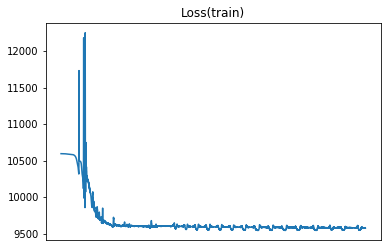

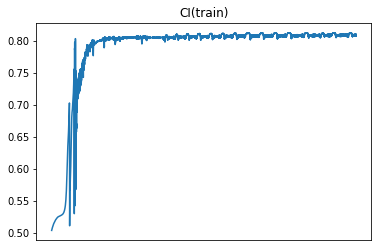

In [2]:
n_features = data['x'].shape[1]
print("features: ", n_features)
model = LDS.LDeepSurv(n_features, [6, 3], 1, 
                      learning_rate=0.001,
                      activation='tanh', 
                      L1_reg=0.01, 
                      L2_reg=0.01, 
                      optimizer='sgd')

model.train(data['x'], {'e': data['e'], 't': data['t']}, 
            num_epoch=3000, iteration=500,
            plot_train_loss=True, plot_train_CI=True)

### 网络测试

使用一致性指数评估（CI）:
- 训练集上的评估
- 独立测试集上的评估

In [3]:
X = data['x']
label = {'e': data['e'], 't': data['t']}
print("CI on train set: %g" % model.eval(X, label))

# 生成测试集数据
test_data = data_config.generate_data(800)
sort_idx = np.argsort(test_data['t'])[::-1]
test_data['x'] = test_data['x'] [sort_idx]
test_data['e'] = test_data['e'] [sort_idx]
test_data['t'] = test_data['t'] [sort_idx]
test_X = test_data['x']
test_label = {'e': test_data['e'], 't': test_data['t']}
print("CI on train set: %g" % model.eval(test_X, test_label))

CI on train set: 0.807163
CI on train set: 0.797372


In [4]:
model.evaluate_var_byWeights()

0th feature score : -0.728218.
1th feature score : 1.
2th feature score : 0.0115546.
3th feature score : -0.00327509.
4th feature score : -0.0484563.
5th feature score : -0.0143632.
6th feature score : 0.00188273.
7th feature score : 0.0102094.
8th feature score : 0.0104849.
9th feature score : -0.0112754.


array([-0.7282185 ,  1.        ,  0.01155464, -0.00327509, -0.04845629,
       -0.01436323,  0.00188273,  0.01020941,  0.01048492, -0.01127543], dtype=float32)

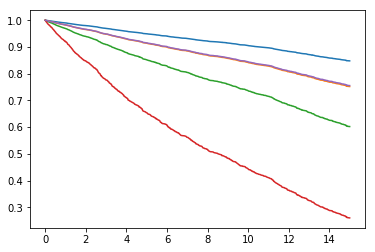

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[ 1.        ,  0.99999399,  0.99998798, ...,  0.84792306,
          0.84792306,  0.84792306],
        [ 1.        ,  0.99998962,  0.99997922, ...,  0.75189372,
          0.75189372,  0.75189372],
        [ 1.        ,  0.99998152,  0.99996303, ...,  0.60201581,
          0.60201581,  0.60201581],
        [ 1.        ,  0.99995095,  0.99990187, ...,  0.26003243,
          0.26003243,  0.26003243],
        [ 1.        ,  0.99998979,  0.99997957, ...,  0.75542358,
          0.75542358,  0.75542358]]),
 array([ 5.        ,  4.99990587,  4.99981167, ...,  3.2172886 ,
         3.2172886 ,  3.2172886 ]))

In [5]:
model.survivalRate(X[0:5])

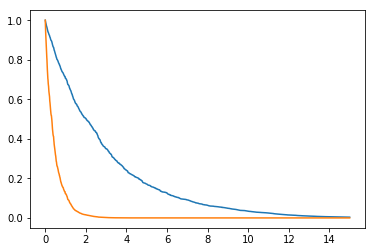

(array([  0.00000000e+00,   5.01984323e-04,   1.33719447e-03, ...,
          1.50000000e+01,   1.50000000e+01,   1.50000000e+01], dtype=float32),
 array([[  1.00000000e+00,   9.99796395e-01,   9.99592685e-01, ...,
           3.72875930e-03,   3.72875930e-03,   3.72875930e-03],
        [  1.00000000e+00,   9.98770770e-01,   9.97542171e-01, ...,
           2.14411286e-15,   2.14411286e-15,   2.14411286e-15]]),
 array([ 2.        ,  1.99856716,  1.99713486, ...,  0.00372876,
         0.00372876,  0.00372876]))

In [9]:
model.survivalRate(X[-2:])

In [11]:
print(X[-2:])
print(label['e'][-2:])
print(label['t'][-2:])

[[-0.57801318  0.2706829  -0.41582355  0.1517856  -0.07731433 -0.78619105
   0.90166128 -0.24884792 -0.05328456  0.34744591]
 [-0.37330073  0.22303852 -0.69448787 -0.21607806 -0.45342973 -0.91201878
   0.7034238   0.78427929 -0.03605074  0.28548568]]
[1 1]
[ 0.00133719  0.00050198]


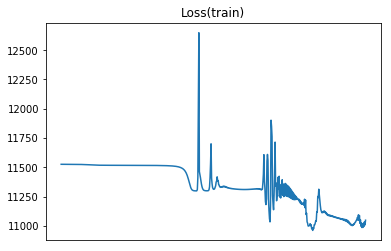

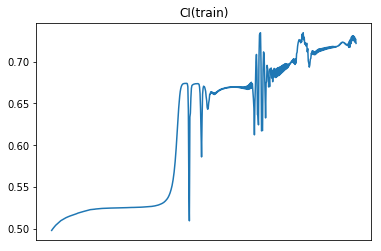

In [6]:
model0 = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01, optimizer='adam')

model0.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

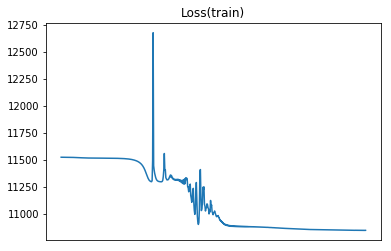

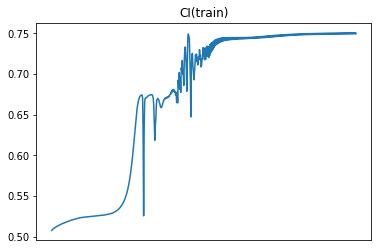

In [4]:
model2 = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01, optimizer='adam')

model2.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

features:  10


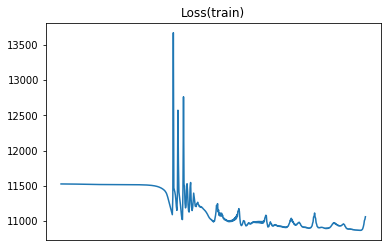

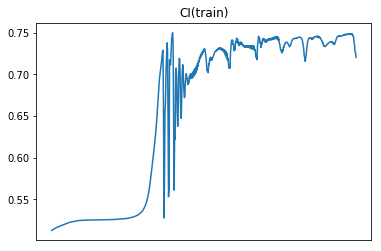

In [3]:
n_features = data['x'].shape[1]
print("features: ", n_features)
model = LDS.LDeepSurv(n_features, [6,3], 1, learning_rate=0.001, activation='tanh', L2_reg=0.01)

model.train(data['x'], {'e': data['e'], 't': data['t']}, num_epoch=600, plot_train_loss=True, plot_train_CI=True)

In [3]:
import tensorflow as tf

print(tf.global_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'training_step/global_step:0' shape=() dtype=int32_ref>]


In [4]:
with tf.Session() as sess:
    c = tf.get_collection('losses')
    x = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    y = tf.get_collection(tf.GraphKeys.WEIGHTS)
    print(c, x, y)

[] [<tf.Tensor 'layer1/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer2/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'layer_last/weights/Regularizer/l1_l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'get_regularization_penalty:0' shape=() dtype=float32>] []


In [5]:
print(tf.trainable_variables())

[<tf.Variable 'layer1/weights:0' shape=(10, 6) dtype=float32_ref>, <tf.Variable 'layer1/biases:0' shape=(6,) dtype=float32_ref>, <tf.Variable 'layer2/weights:0' shape=(6, 3) dtype=float32_ref>, <tf.Variable 'layer2/biases:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'layer_last/weights:0' shape=(3, 1) dtype=float32_ref>, <tf.Variable 'layer_last/biases:0' shape=(1,) dtype=float32_ref>]
